In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All imports successful! 🎉
Pandas version: 2.2.2
NumPy version: 1.26.4


In [19]:
# Load the correct dataset
data = pd.read_csv('../data/basic_ab_test.csv')

# Verify we have everything
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print("\nBreakdown by device and group:")
print(data.groupby(['device', 'group']).size())

Dataset loaded correctly!
Shape: (50000, 4)
Columns: ['user_id', 'group', 'device', 'converted']

Breakdown by device and group:
device   group    
desktop  control       7440
         treatment     7405
mobile   control      17560
         treatment    17595
dtype: int64


In [23]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Separate mobile and desktop data
mobile_data = data[data['device'] == 'mobile']
desktop_data = data[data['device'] == 'desktop']

print("=== MOBILE USERS ANALYSIS ===")
mobile_control = mobile_data[mobile_data['group'] == 'control']
mobile_treatment = mobile_data[mobile_data['group'] == 'treatment']

mobile_control_conv = mobile_control['converted'].sum()
mobile_treatment_conv = mobile_treatment['converted'].sum()
mobile_control_n = len(mobile_control)
mobile_treatment_n = len(mobile_treatment)

print(f"Mobile Control: {mobile_control_conv}/{mobile_control_n} = {mobile_control_conv/mobile_control_n:.4f}")
print(f"Mobile Treatment: {mobile_treatment_conv}/{mobile_treatment_n} = {mobile_treatment_conv/mobile_treatment_n:.4f}")

# Z-test for mobile
mobile_counts = np.array([mobile_treatment_conv, mobile_control_conv])
mobile_nobs = np.array([mobile_treatment_n, mobile_control_n])
mobile_z, mobile_p = proportions_ztest(mobile_counts, mobile_nobs)

print(f"Mobile Z-test: Z={mobile_z:.3f}, p={mobile_p:.4f}")
print(f"Mobile significant? {'YES' if mobile_p < 0.05 else 'NO'}")

=== MOBILE USERS ANALYSIS ===
Mobile Control: 341/17560 = 0.0194
Mobile Treatment: 415/17595 = 0.0236
Mobile Z-test: Z=2.693, p=0.0071
Mobile significant? YES


In [25]:
print("\n=== DESKTOP USERS ANALYSIS ===")
desktop_control = desktop_data[desktop_data['group'] == 'control']
desktop_treatment = desktop_data[desktop_data['group'] == 'treatment']

desktop_control_conv = desktop_control['converted'].sum()
desktop_treatment_conv = desktop_treatment['converted'].sum()
desktop_control_n = len(desktop_control)
desktop_treatment_n = len(desktop_treatment)

print(f"Desktop Control: {desktop_control_conv}/{desktop_control_n} = {desktop_control_conv/desktop_control_n:.4f}")
print(f"Desktop Treatment: {desktop_treatment_conv}/{desktop_treatment_n} = {desktop_treatment_conv/desktop_treatment_n:.4f}")

# Z-test for desktop
desktop_counts = np.array([desktop_treatment_conv, desktop_control_conv])
desktop_nobs = np.array([desktop_treatment_n, desktop_control_n])
desktop_z, desktop_p = proportions_ztest(desktop_counts, desktop_nobs)

print(f"Desktop Z-test: Z={desktop_z:.3f}, p={desktop_p:.4f}")
print(f"Desktop significant? {'YES' if desktop_p < 0.05 else 'NO'}")


=== DESKTOP USERS ANALYSIS ===
Desktop Control: 172/7440 = 0.0231
Desktop Treatment: 218/7405 = 0.0294
Desktop Z-test: Z=2.408, p=0.0161
Desktop significant? YES


In [27]:
# Multiple comparisons correction (Bonferroni)
original_alpha = 0.05
corrected_alpha = original_alpha / 2  # We ran 2 tests

print(f"=== MULTIPLE COMPARISONS CORRECTION ===")
print(f"Original α = {original_alpha}")
print(f"Bonferroni corrected α = {corrected_alpha:.3f}")
print(f"Mobile significant after correction? {'YES' if mobile_p < corrected_alpha else 'NO'}")
print(f"Desktop significant after correction? {'YES' if desktop_p < corrected_alpha else 'NO'}")

=== MULTIPLE COMPARISONS CORRECTION ===
Original α = 0.05
Bonferroni corrected α = 0.025
Mobile significant after correction? YES
Desktop significant after correction? YES


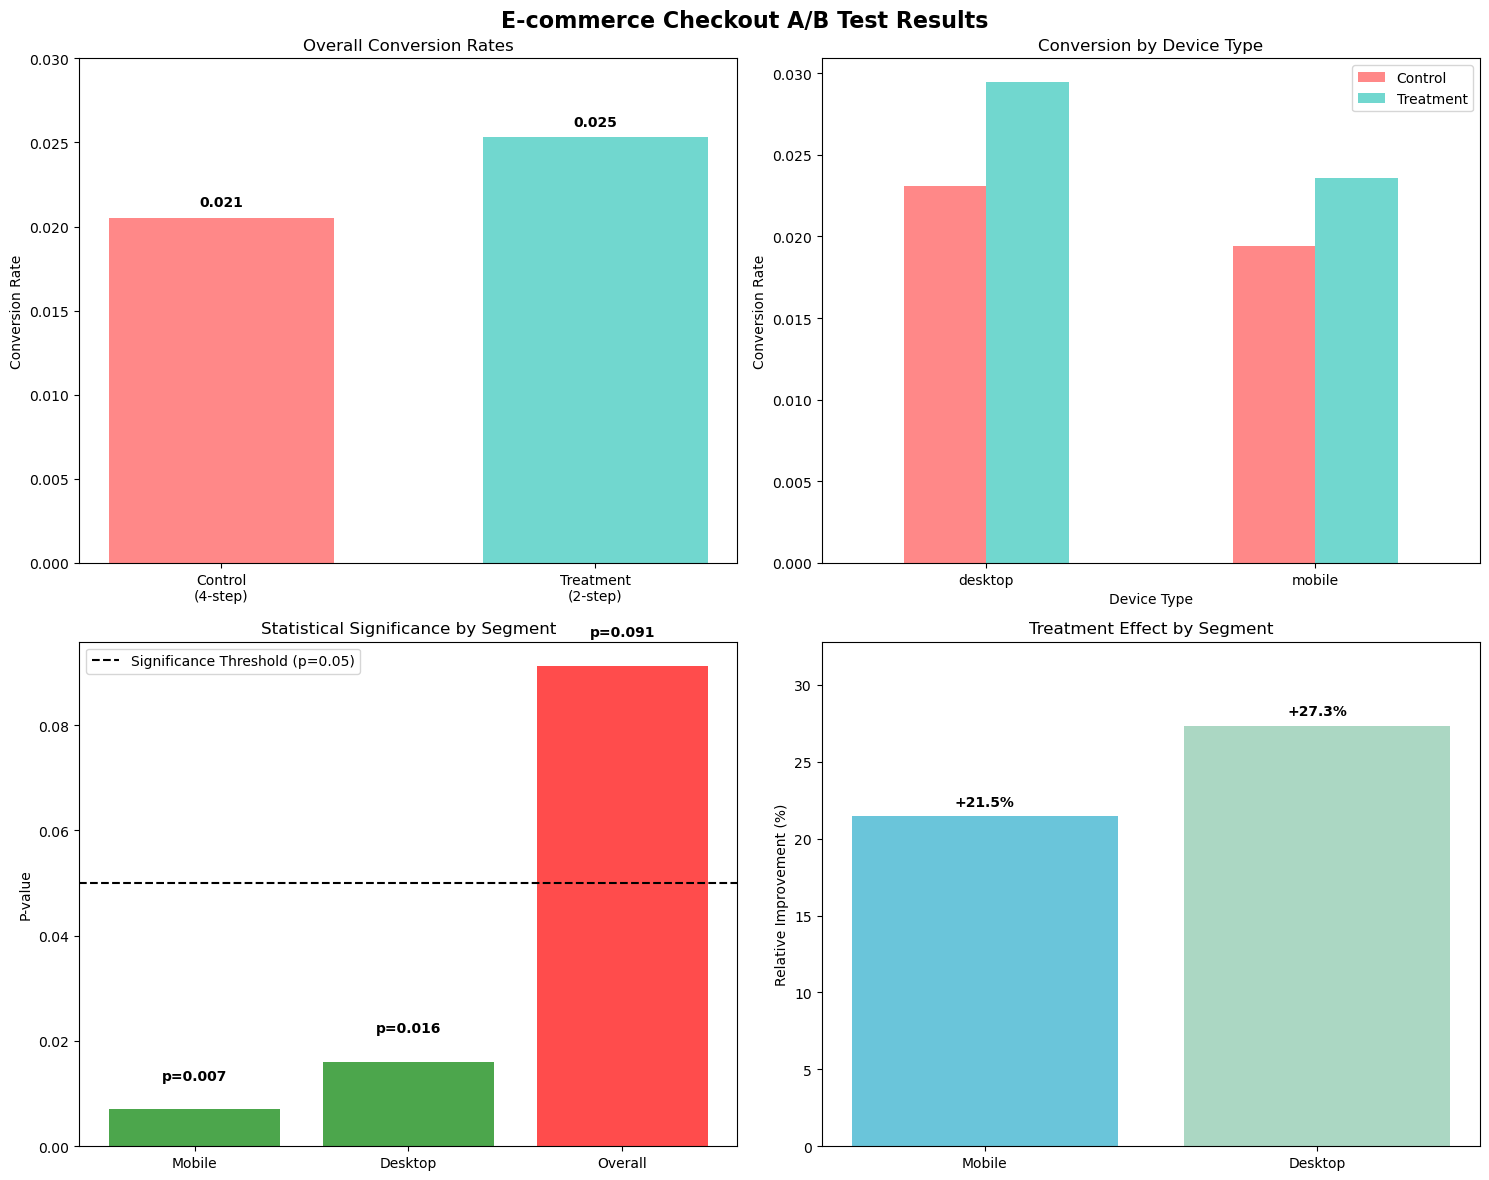

Dashboard saved to ./reports/ab_test_results_dashboard.png


In [31]:
# Set up professional styling
plt.style.use('default')
sns.set_palette("Set2")

# Create a comprehensive results dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('E-commerce Checkout A/B Test Results', fontsize=16, fontweight='bold')

# 1. Overall conversion rates
overall_summary = data.groupby('group')['converted'].agg(['count', 'sum', 'mean'])
ax1.bar(['Control\n(4-step)', 'Treatment\n(2-step)'], 
        [overall_summary.loc['control', 'mean'], overall_summary.loc['treatment', 'mean']], 
        color=['#FF6B6B', '#4ECDC4'], alpha=0.8, width=0.6)
ax1.set_ylabel('Conversion Rate')
ax1.set_title('Overall Conversion Rates')
ax1.set_ylim(0, 0.03)

# Add value labels
for i, v in enumerate([overall_summary.loc['control', 'mean'], overall_summary.loc['treatment', 'mean']]):
    ax1.text(i, v + 0.0005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Segmented results
segment_data = data.groupby(['device', 'group'])['converted'].mean().unstack()
segment_data.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
ax2.set_title('Conversion by Device Type')
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Device Type')
ax2.legend(['Control', 'Treatment'])
ax2.tick_params(axis='x', rotation=0)

# 3. Statistical significance visualization
segments = ['Mobile', 'Desktop', 'Overall']
p_values = [0.0071, 0.0161, 0.0913]  # Our actual results
colors = ['green' if p < 0.05 else 'red' for p in p_values]

bars = ax3.bar(segments, p_values, color=colors, alpha=0.7)
ax3.axhline(y=0.05, color='black', linestyle='--', label='Significance Threshold (p=0.05)')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Significance by Segment')
ax3.legend()

# Add value labels
for bar, p in zip(bars, p_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'p={p:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Business impact
mobile_control_rate = data[(data['device'] == 'mobile') & (data['group'] == 'control')]['converted'].mean()
mobile_treatment_rate = data[(data['device'] == 'mobile') & (data['group'] == 'treatment')]['converted'].mean()
desktop_control_rate = data[(data['device'] == 'desktop') & (data['group'] == 'control')]['converted'].mean()
desktop_treatment_rate = data[(data['device'] == 'desktop') & (data['group'] == 'treatment')]['converted'].mean()

lifts = [
    (mobile_treatment_rate - mobile_control_rate) / mobile_control_rate * 100,
    (desktop_treatment_rate - desktop_control_rate) / desktop_control_rate * 100
]

ax4.bar(['Mobile', 'Desktop'], lifts, color=['#45B7D1', '#96CEB4'], alpha=0.8)
ax4.set_ylabel('Relative Improvement (%)')
ax4.set_title('Treatment Effect by Segment')
ax4.set_ylim(0, max(lifts) * 1.2)

# Add value labels
for i, lift in enumerate(lifts):
    ax4.text(i, lift + 0.5, f'+{lift:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/ab_test_results_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Dashboard saved to ./reports/ab_test_results_dashboard.png")